# Download the MNIST dataset

In [ ]:
from keras.datasets import mnist
(orig_train_data_images, _), (orig_test_data_images, _) = mnist.load_data()

In [86]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

## Flattening MNIST data

In [87]:
orig_train_data_images = orig_train_data_images.reshape((len(orig_train_data_images), np.prod(orig_train_data_images.shape[1:])))
orig_test_data_images = orig_test_data_images.reshape((len(orig_test_data_images), np.prod(orig_test_data_images.shape[1:])))

In [91]:
#flip pixels to create a new noisy training set
noisy_train_data_images = np.zeros((12000, 784))
train_data_images = np.zeros((12000, 784))
downsampling_mask = np.random.uniform(0,1,120000)
downsampling_flags = np.where(downsampling_mask < 0.1, 1, 0)
i = 0
j = 0
for image in orig_train_data_images:
    if downsampling_flags[i] == 1 and j < 12000:
        for k in range(0,2):
            mask = np.random.uniform(0,1,784)
            im = np.array(image)
            new_image = np.where(mask > 0.03,im, 255-im) 
            noisy_train_data_images[j,:] = new_image
            train_data_images[j,:] = image
            j=j+1
    i=i+1
    
%xdel downsampling_mask
%xdel downsampling_flags
%xdel orig_train_data_images

In [96]:
#flip pixels to create a new noisy test set
noisy_test_data_images = np.zeros((10000, 784))
j = 0
for image in orig_test_data_images:
        mask = np.random.uniform(0,1,784)
        im = np.array(image)
        new_image = np.where(mask > 0.03,im, 255-im) 
        noisy_test_data_images[j,:] = new_image
        j=j+1

In [97]:
#normalize all pixels
norm_orig_train_data_images = np.divide(train_data_images,255.0)
norm_orig_test_data_images = np.divide(orig_test_data_images,255.0)
norm_noisy_train_data_images = np.divide(noisy_train_data_images,255.0)
norm_noisy_test_data_images = np.divide(noisy_test_data_images,255.0)

#reshape training and testing data sets
norm_orig_train_data_images = np.reshape(norm_orig_train_data_images, (len(norm_orig_train_data_images), 28, 28, 1))
norm_orig_test_data_images = np.reshape(norm_orig_test_data_images, (len(norm_orig_test_data_images), 28, 28, 1))
norm_noisy_train_data_images = np.reshape(norm_noisy_train_data_images, (len(norm_noisy_train_data_images), 28, 28, 1))
norm_noisy_test_data_images = np.reshape(norm_noisy_test_data_images, (len(norm_noisy_test_data_images), 28, 28, 1))


## CNN 1

    
    


In [29]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3,3), activation='relu', padding='same', dilation_rate=(1,1))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [30]:
from keras.callbacks import TensorBoard
autoencoder.fit(norm_noisy_train_data_images, norm_orig_train_data_images,
               epochs=10,
               batch_size=128,
               shuffle=True,
               validation_data=(norm_noisy_test_data_images, norm_orig_test_data_images),
               callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])


Train on 12000 samples, validate on 10000 samples
Epoch 1/10
12000/12000 [==============================] - 151s - loss: 0.3238 - mean_squared_error: 0.0840 - val_loss: 0.1936 - val_mean_squared_error: 0.0445
Epoch 2/10
12000/12000 [==============================] - 153s - loss: 0.1612 - mean_squared_error: 0.0328 - val_loss: 0.1407 - val_mean_squared_error: 0.0255
Epoch 3/10
12000/12000 [==============================] - 152s - loss: 0.1292 - mean_squared_error: 0.0222 - val_loss: 0.1180 - val_mean_squared_error: 0.0182
Epoch 4/10
12000/12000 [==============================] - 152s - loss: 0.1149 - mean_squared_error: 0.0174 - val_loss: 0.1062 - val_mean_squared_error: 0.0146
Epoch 5/10
12000/12000 [==============================] - 151s - loss: 0.1068 - mean_squared_error: 0.0146 - val_loss: 0.1018 - val_mean_squared_error: 0.0132
Epoch 6/10
12000/12000 [==============================] - 151s - loss: 0.1003 - mean_squared_error: 0.0125 - val_loss: 0.0953 - val_mean_squared_error: 0.0

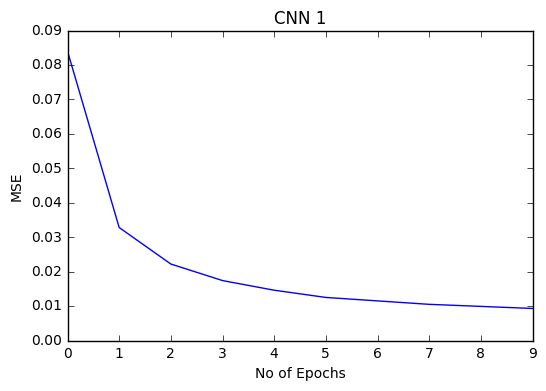

In [35]:
MSE1 = [0.0840 ,0.0328 ,  0.0222 , 0.0174 , 0.0146 , 0.0125 , 0.0115 , 0.0105 , 0.0099 , 0.0093 ]
x1, y1 = (zip(*enumerate(MSE1)))

plt.plot(x1, y1)
plt.title("CNN 1")
plt.xlabel("No of Epochs")
plt.ylabel("MSE")
plt.show()

In [94]:
decoded_imgs  = autoencoder.predict(norm_noisy_test_data_images)
errors = []
for i in range(norm_noisy_test_data_images.shape[0]):
    errors.append(np.sum((decoded_imgs[i] - norm_orig_test_data_images[i])**2))
      
best_set =  np.argpartition(errors, 10)[:10]
worst_set = np.argpartition(errors, -10)[-10:]
    
    
    

Plotting the best set

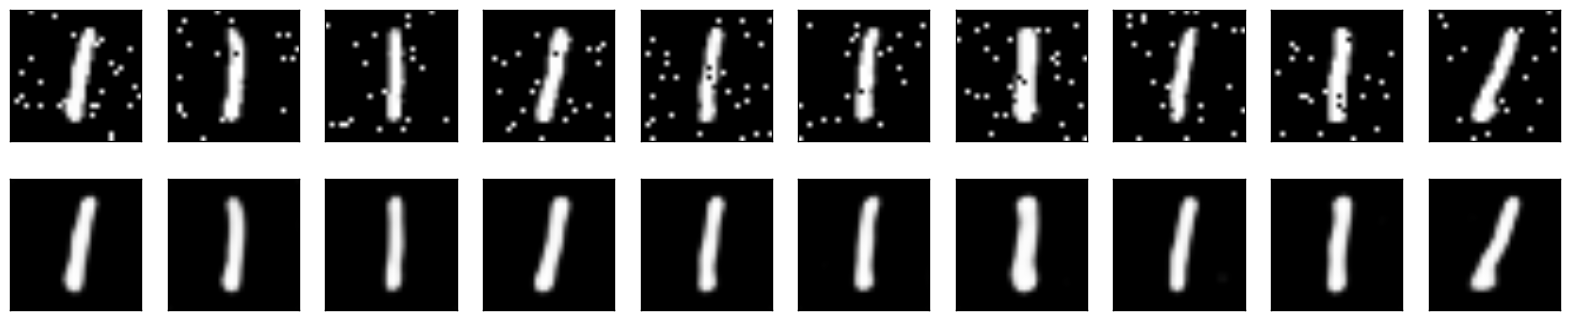

In [109]:
plt.figure(figsize=(20, 4))

for i, j in enumerate(best_set):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data_images[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Plotting the worst set

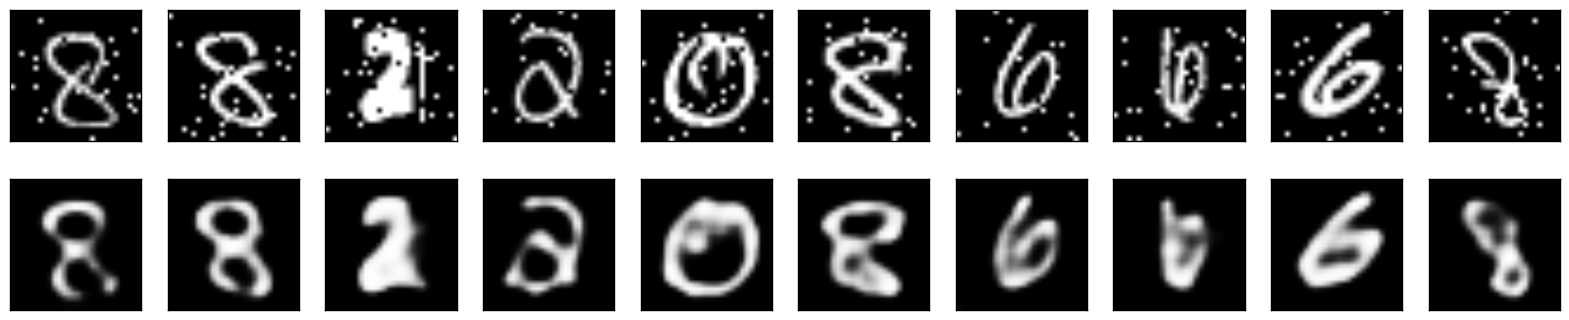

In [121]:
plt.figure(figsize=(20, 4))

for i, j in enumerate(worst_set):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data_images[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN 2

In [47]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (2,2), activation='relu', padding='same', dilation_rate=(1,1))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (2,2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (2,2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (2,2), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (2,2), activation='relu', padding='same')(x)

autoencoder2 = Model(input_img, decoded)
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [48]:
autoencoder2.fit(norm_noisy_train_data_images, norm_orig_train_data_images,
               epochs=10,
               batch_size=128,
               shuffle=True,
               validation_data=(norm_noisy_test_data_images, norm_orig_test_data_images),
               callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/10
12000/12000 [==============================] - 125s - loss: 0.3363 - mean_squared_error: 0.0837 - val_loss: 0.2706 - val_mean_squared_error: 0.0665
Epoch 2/10
12000/12000 [==============================] - 125s - loss: 0.2372 - mean_squared_error: 0.0557 - val_loss: 0.2127 - val_mean_squared_error: 0.0481
Epoch 3/10
12000/12000 [==============================] - 126s - loss: 0.1980 - mean_squared_error: 0.0444 - val_loss: 0.1888 - val_mean_squared_error: 0.0418
Epoch 4/10
12000/12000 [==============================] - 125s - loss: 0.1882 - mean_squared_error: 0.0411 - val_loss: 0.1822 - val_mean_squared_error: 0.0399
Epoch 5/10
12000/12000 [==============================] - 128s - loss: 0.1810 - mean_squared_error: 0.0391 - val_loss: 0.1789 - val_mean_squared_error: 0.0384
Epoch 6/10
12000/12000 [==============================] - 125s - loss: 0.1793 - mean_squared_error: 0.0382 - val_loss: 0.1763 - val_mean_squared_error: 0.0

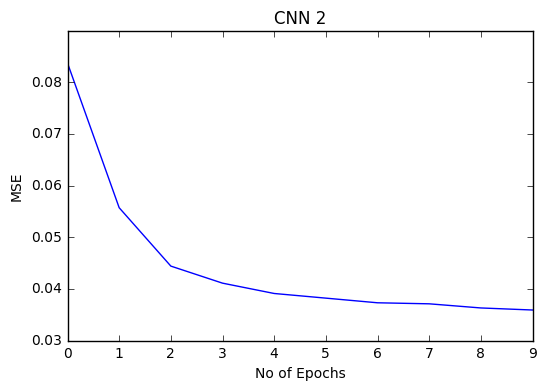

In [54]:
MSE2 = [ 0.0837 ,0.0557  ,  0.0444 , 0.0411, 0.0391 ,0.0382 , 0.0373 , 0.0371, 0.0363 , 0.0359 ]
x2, y2 = (zip(*enumerate(MSE2)))

plt.plot(x2, y2)
plt.title("CNN 2")
plt.xlabel("No of Epochs")
plt.ylabel("MSE")
plt.show()

In [81]:
decoded_imgs2  = autoencoder2.predict(norm_noisy_test_data_images)
errors2 = []
for i in range(norm_noisy_test_data_images.shape[0]):
    errors2.append(np.sum((decoded_imgs[i] - norm_orig_test_data_images[i])**2))
      
best_set2 =  np.argpartition(errors2, 10)[:10]
worst_set2 = np.argpartition(errors2, -10)[-10:]
    
    
    

Plotting the best set

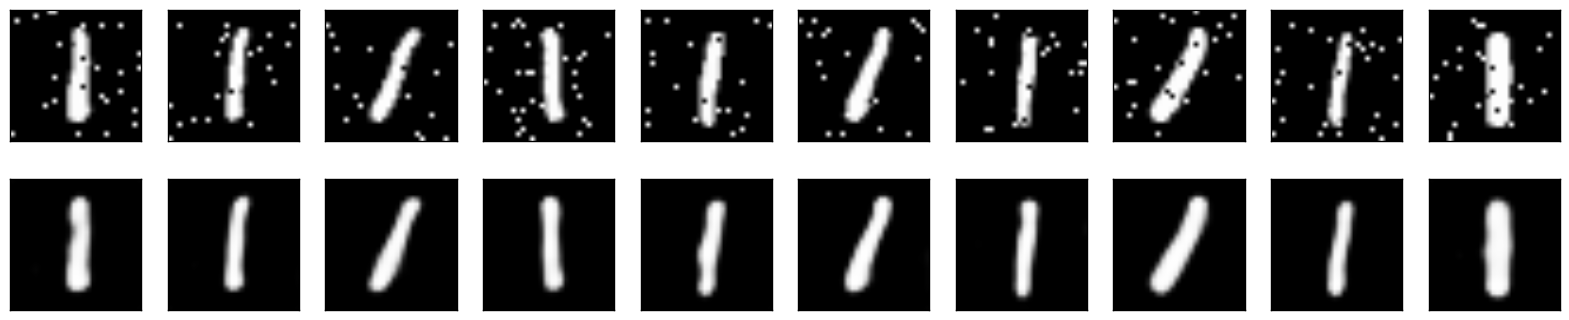

In [110]:
plt.figure(figsize=(20, 4))

for i, j in enumerate(best_set2):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data_images[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Plotting the worst set

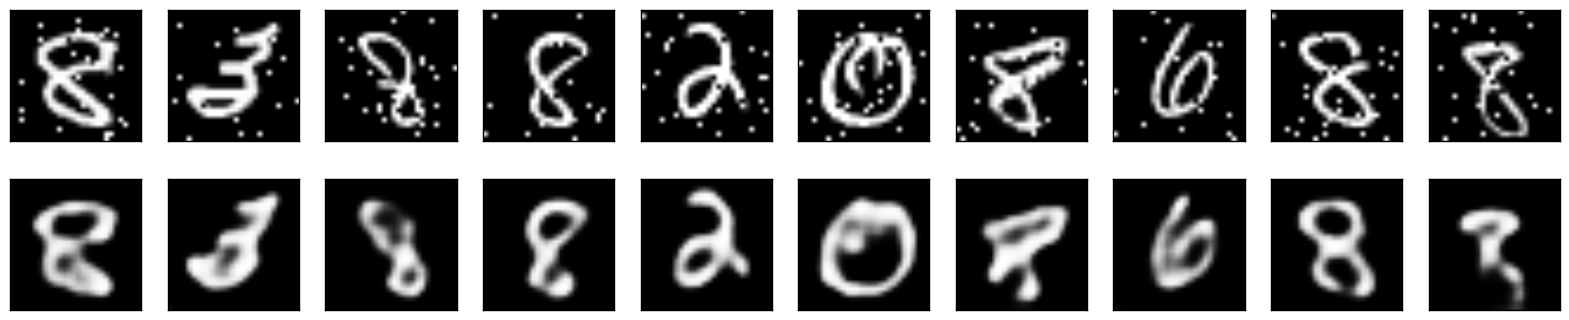

In [120]:
plt.figure(figsize=(20, 4))

for i, j in enumerate(worst_set2):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data_images[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN 3

In [49]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3,3), activation='sigmoid', padding='same', dilation_rate=(1,1))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder3 = Model(input_img, decoded)
autoencoder3.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [50]:
autoencoder3.fit(norm_noisy_train_data_images, norm_orig_train_data_images,
               epochs=10,
               batch_size=128,
               shuffle=True,
               validation_data=(norm_noisy_test_data_images, norm_orig_test_data_images),
               callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/10
12000/12000 [==============================] - 151s - loss: 0.4203 - mean_squared_error: 0.1067 - val_loss: 0.3948 - val_mean_squared_error: 0.0981
Epoch 2/10
12000/12000 [==============================] - 151s - loss: 0.3579 - mean_squared_error: 0.0882 - val_loss: 0.3175 - val_mean_squared_error: 0.0797
Epoch 3/10
12000/12000 [==============================] - 152s - loss: 0.2961 - mean_squared_error: 0.0751 - val_loss: 0.2902 - val_mean_squared_error: 0.0760
Epoch 4/10
12000/12000 [==============================] - 153s - loss: 0.2821 - mean_squared_error: 0.0728 - val_loss: 0.2787 - val_mean_squared_error: 0.0723
Epoch 5/10
12000/12000 [==============================] - 150s - loss: 0.2786 - mean_squared_error: 0.0721 - val_loss: 0.2776 - val_mean_squared_error: 0.0721
Epoch 6/10
12000/12000 [==============================] - 153s - loss: 0.2773 - mean_squared_error: 0.0718 - val_loss: 0.2760 - val_mean_squared_error: 0.0

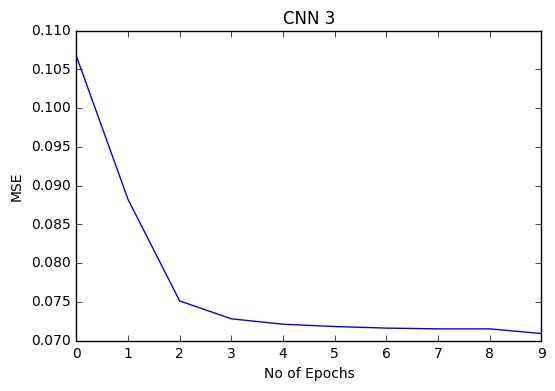

In [55]:
MSE3 = [ 0.1067 , 0.0882  , 0.0751 , 0.0728 , 0.0721 ,0.0718,  0.0716 ,  0.0715,  0.0715 , 0.0709]
x3, y3 = (zip(*enumerate(MSE3)))

plt.plot(x3, y3)
plt.title("CNN 3")
plt.xlabel("No of Epochs")
plt.ylabel("MSE")
plt.show()

In [111]:
decoded_imgs3  = autoencoder3.predict(norm_noisy_test_data_images)
errors3 = []
for i in range(norm_noisy_test_data_images.shape[0]):
    errors3.append(np.sum((decoded_imgs[i] - norm_orig_test_data_images[i])**2))
      
best_set3 =  np.argpartition(errors3, 10)[:10]
worst_set3 = np.argpartition(errors3, -10)[-10:]
    
    
    

Plotting the best set

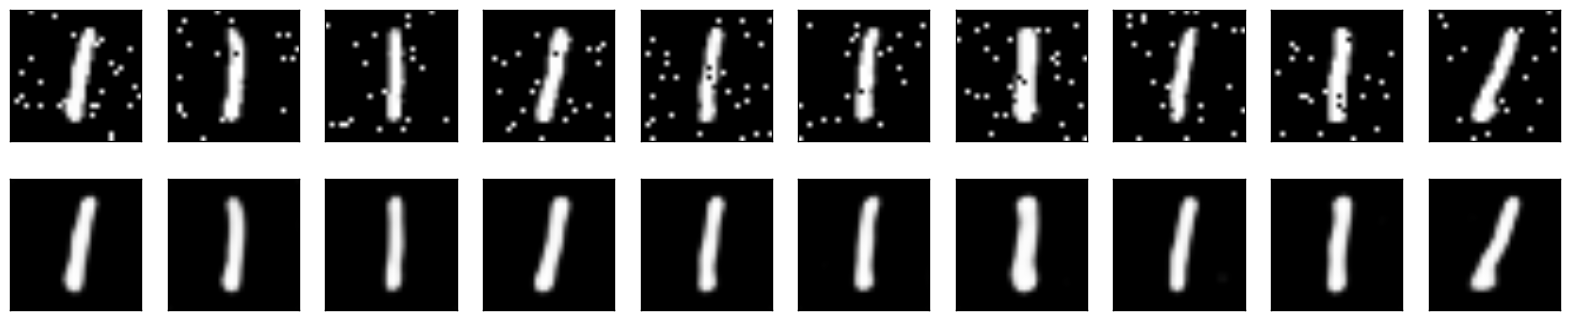

In [117]:
plt.figure(figsize=(20, 4))

for i, j in enumerate(best_set3):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data_images[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Plotting the worst set

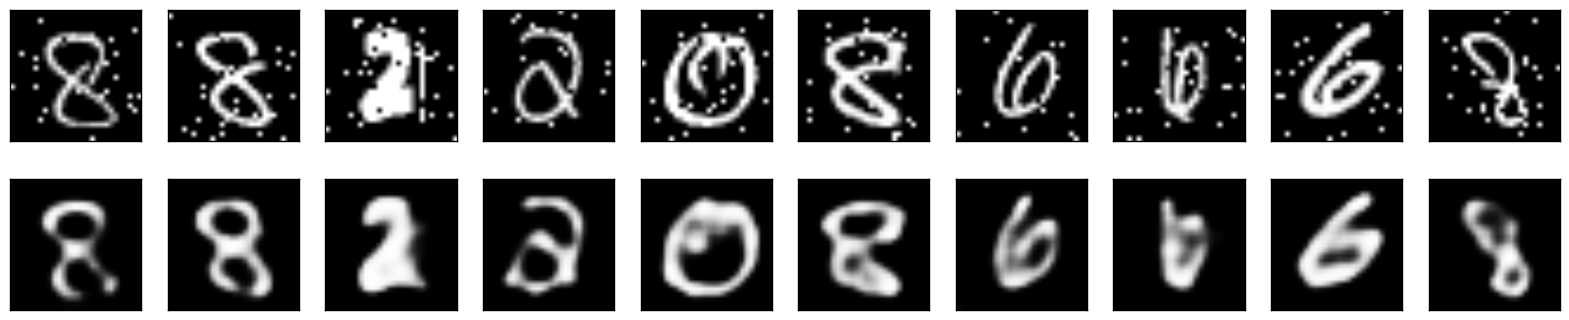

In [118]:
plt.figure(figsize=(20, 4))

for i, j in enumerate(worst_set3):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data_images[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## CNN 4

In [52]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (5,5), activation='relu', padding='same', dilation_rate=(1,1))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5,5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (5,5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (5,5), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (5,5), activation='sigmoid', padding='same')(x)

autoencoder4 = Model(input_img, decoded)
autoencoder4.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [53]:
autoencoder4.fit(norm_noisy_train_data_images, norm_orig_train_data_images,
               epochs=10,
               batch_size=128,
               shuffle=True,
               validation_data=(norm_noisy_test_data_images, norm_orig_test_data_images),
               callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/10
12000/12000 [==============================] - 209s - loss: 0.2898 - mean_squared_error: 0.0729 - val_loss: 0.1757 - val_mean_squared_error: 0.0366
Epoch 2/10
12000/12000 [==============================] - 210s - loss: 0.1492 - mean_squared_error: 0.0286 - val_loss: 0.1229 - val_mean_squared_error: 0.0198
Epoch 3/10
12000/12000 [==============================] - 211s - loss: 0.1203 - mean_squared_error: 0.0191 - val_loss: 0.1117 - val_mean_squared_error: 0.0162
Epoch 4/10
12000/12000 [==============================] - 211s - loss: 0.1091 - mean_squared_error: 0.0154 - val_loss: 0.1096 - val_mean_squared_error: 0.0155
Epoch 5/10
12000/12000 [==============================] - 211s - loss: 0.1027 - mean_squared_error: 0.0133 - val_loss: 0.1002 - val_mean_squared_error: 0.0125
Epoch 6/10
12000/12000 [==============================] - 212s - loss: 0.0978 - mean_squared_error: 0.0117 - val_loss: 0.0975 - val_mean_squared_error: 0.0

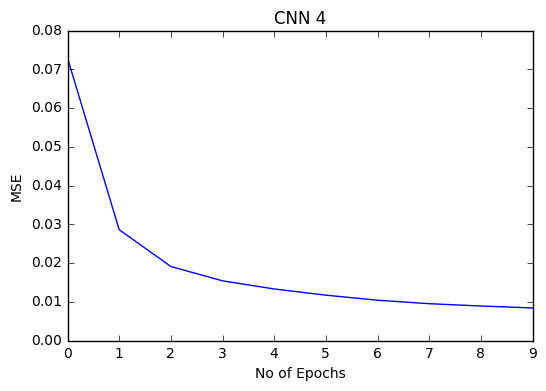

In [56]:
MSE4 = [  0.0729 , 0.0286,0.0191, 0.0154,  0.0133 ,0.0117,  0.0104 ,  0.0095,  0.0089 , 0.0084]
x4, y4 = (zip(*enumerate(MSE4)))

plt.plot(x4, y4)
plt.title("CNN 4")
plt.xlabel("No of Epochs")
plt.ylabel("MSE")
plt.show()

In [114]:
decoded_imgs4  = autoencoder4.predict(norm_noisy_test_data_images)
errors4 = []
for i in range(norm_noisy_test_data_images.shape[0]):
    errors4.append(np.sum((decoded_imgs[i] - norm_orig_test_data_images[i])**2))
      
best_set4 =  np.argpartition(errors4, 10)[:10]
worst_set4 = np.argpartition(errors4, -10)[-10:]
    
    
    

Plotting the best set

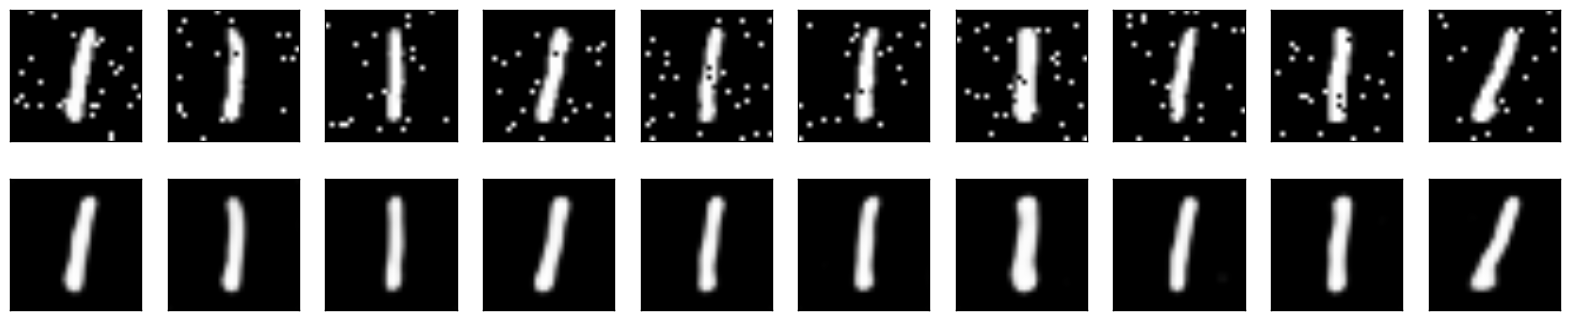

In [115]:
plt.figure(figsize=(20, 4))

for i, j in enumerate(best_set4):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data_images[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Plotting the worst set

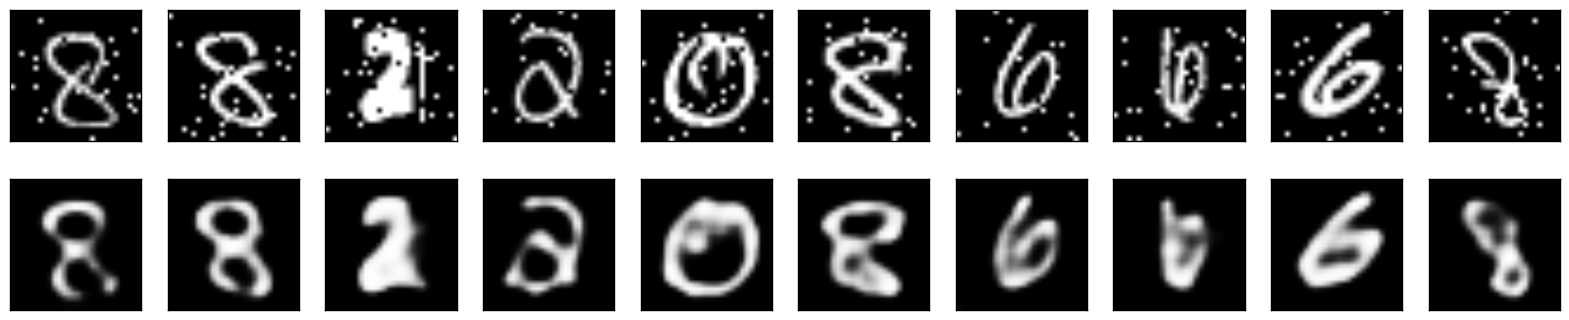

In [119]:
plt.figure(figsize=(20, 4))

for i, j in enumerate(worst_set4):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data_images[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()